<a href="https://colab.research.google.com/github/DUbennett/analysis/blob/main/Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Influential users in the space
* attributes of hashtags
* emotions, sentiments, fake news, toxic, sarcasm of tweets, users


In [1]:
# Variables for use in notebook
max_tweets_to_get = 100
search_term = 'climate change'

In [ ]:
# Set-up Colab Environment to use John Snow Lab NLU
!wget https://setup.johnsnowlabs.com/nlu/colab.sh -O - | bash
import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# Install packages in environment
! pip install nlu pyspark
! pip install pandas
! pip install seaborn
! pip install matplotlib
! pip install emoji
! pip install numpy
! pip install sklearn
! pip install contractions

In [2]:
# Import libraries
import nlu
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import emoji
import numpy as np
import contractions
import re
plt.rcParams['figure.figsize'] = [16, 9]

In [ ]:
# Set-up NLU pipelines
# TAKES A LONG TIME!!!!!!
# sentiment = nlu.load('sentiment')
# emotion = nlu.load('emotion')
# spell = nlu.load('spell')
# fakeNews = nlu.load('en.classify.fakenews')
# spam = nlu.load('en.classify.spam')
# toxic = nlu.load('en.classify.toxic')
# twitterSentiment = nlu.load('en.sentiment.twitter')
# sarcasm = nlu.load('en.classify.sarcasm')
# yake = nlu.load('yake')

In [3]:
# Create helper functions

def cleanText(text):
    # r'(@\w+)' removes handles
    # r'https?://\S+|www\.\S+' removes web links
    # r'\R' removes new lines
    # r'[^a-zA-Z0-9_ ] removes punctuation

    text = str(text)
    text = emoji.demojize(text)
    text = contractions.fix(text)
    text = re.sub(r'(@\w+)|\\R', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'(RT)', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9 \.]', ' ', text)
    text = " ".join(text.split())
    return text.strip()

def finalTweet(row):
    if row['truncated'] == False:
        return row['text']
    elif row['truncated'] == False and row['full_text'] == np.NaN:
        return row['text']
    else:
        return row['full_text']

def time_scale(df):
  min = df['created_at'].min()
  max = df['created_at'].max()
  time_range = max - min
  if time_range.seconds <= 60:
    return 'S'
  elif time_range.seconds in range(6 ,3600):
    return ('min', 'Minute')
  elif time_range.seconds in range(3600, 86400):
    return ('H', 'Hour')
  elif time_range.days in range (1,28):
    return ('D', 'Days')
  elif time_range.days in range (28, 180):
    return ('W', 'Week')
  elif time_range.days in range (180,730):
    return ('M', 'Month')
  else:
    return ('Y', 'Year')

In [ ]:
# Set-up Twitter Auths
client_key = 'qkuKRLkpbjSHpv6IDzCYg0iEn'
client_secret =  'wtYgaslqr4OWRaEjVWlzez7LVqzg8yxTv54IqdWSDoHzuxiAjy'
import requests
import base64

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')
base_url = 'https://api.twitter.com/'
auth_endpoint = base_url+'oauth2/token'

auth_headers = { 'Authorization': 'Basic {}'.format(b64_encoded_key),
                'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'}

auth_data = { 'grant_type': 'client_credentials'}

response = requests.post(auth_endpoint, headers=auth_headers, data=auth_data)
response.status_code
json_data =  response.json()
# json_data
access_token = json_data['access_token']

In [ ]:
## Get tweet text (regular length tweets)
max_tweets=max_tweets_to_get
tw_limit=100# we can get only 100 tweet per call with standard search api
tweets = []
search_headers = {'Authorization': 'Bearer {}'.format(access_token)    
}

parameters = { 'q': search_term,
                    'result_type': 'recent',
                    'lang': 'en',
                    # 'tweet_mode': 'extended',
                    'count': 100 }

search_url = base_url+'1.1/search/tweets.json'

response = requests.get(search_url, headers=search_headers, params=parameters)
search_tweets = response.json()
len(search_tweets['statuses'])
tweets +=search_tweets['statuses']
ids = [tw['id'] for tw in search_tweets['statuses']]
min_id = min(ids)
tw_ids = []
tw_ids+=ids
for  i in range(max_tweets//tw_limit -1):
    parameters = { 'q': search_term,
                    'result_type': 'recent',
                'count': tw_limit,
                'max_id': min_id
                 }
    print("searching tweets with id  < {}".format(min_id))
    search_url = base_url+'1.1/search/tweets.json'
    response = requests.get(search_url, headers=search_headers, params=parameters)
    search_tweets = response.json()
    ids = [tw['id'] for tw in search_tweets['statuses']]
    tw_ids+=ids
    print(i, len(search_tweets['statuses']))
    min_id = min(ids)
    tweets +=search_tweets['statuses']
    print('Total tweets retrieved= {}'.format(len(tweets)))


In [ ]:
## Get extended text (text of truncated tweets)
max_tweets=max_tweets_to_get
tw_limit=100# we can get only 100 tweet per call with standard search api
tweets2 = []
search_headers = {'Authorization': 'Bearer {}'.format(access_token)    
}

parameters = { 'q': search_term,
                    'result_type': 'recent',
                    'lang': 'en',
                    'tweet_mode': 'extended',
                    'count': 100 }

search_url = base_url+'1.1/search/tweets.json'

response = requests.get(search_url, headers=search_headers, params=parameters)
search_tweets2 = response.json()
len(search_tweets2['statuses'])
tweets2 +=search_tweets2['statuses']
ids = [tw['id'] for tw in search_tweets2['statuses']]
min_id = min(ids)
tw_ids = []
tw_ids+=ids
for  i in range(max_tweets//tw_limit -1):
    parameters = { 'q': search_term,
                    'result_type': 'recent',
                'count': tw_limit,
                'max_id': min_id
                 }
    print("searching tweets with id  < {}".format(min_id))
    search_url = base_url+'1.1/search/tweets.json'
    response = requests.get(search_url, headers=search_headers, params=parameters)
    search_tweets2 = response.json()
    ids = [tw['id'] for tw in search_tweets2['statuses']]
    tw_ids+=ids
    print(i, len(search_tweets2['statuses']))
    min_id = min(ids)
    tweets2 +=search_tweets2['statuses']
    print('Total tweets retrieved= {}'.format(len(tweets)))

In [224]:
# Create dfs for collected tweets
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.DataFrame(tweets2)
# Clean-up the full text tweets df by dropping columns that aren't needed and NAs
tweets_df2 = tweets_df2[['id', 'full_text']].dropna()

In [225]:
tweets_df

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Mon Nov 22 02:05:11 +0000 2021,1462603030617071617,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1462603019619549185, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 4035053313, 'id_str': '4035053313', 'na...",None,None,None,None,False,0,0,False,False,False,en,NaN,NaN,NaN,NaN
1,Mon Nov 22 02:05:10 +0000 2021,1462603028658147330,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 34159062, 'id_str': '34159062', 'name':...",None,None,None,None,False,0,0,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Nov 22 02:05:08 +0000 2021,1462603020839972866,1462603020839972866,"RT @YaleE360: In the warm months, animals head...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 20686254, 'id_str': '20686254', 'name':...",None,None,None,None,False,8,0,False,False,NaN,en,{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,NaN,NaN,NaN
3,Mon Nov 22 02:05:08 +0000 2021,1462603020743626754,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 461399311, 'id_str': '461399311', 'name...",None,None,None,None,False,979,0,False,False,NaN,en,{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,NaN,NaN,NaN
4,Mon Nov 22 02:05:02 +0000 2021,1462602994067730432,1462602994067730432,RT @RightWingJewess: I believe:\nThere are onl...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 779879391606087680, 'id_str': '77987939...",None,None,None,None,False,73,0,False,False,NaN,en,{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Mon Nov 22 02:01:07 +0000 2021,1462602009995931648,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 2920468975, 'id_str': '2920468975', 'na...",None,None,None,None,False,158,0,False,False,NaN,en,{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,NaN,NaN,NaN
96,Mon Nov 22 02:01:07 +0000 2021,1462602007550873615,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 472226568, 'id_str': '472226568', 'name...",None,None,None,None,False,1,0,False,False,NaN,en,{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,NaN,NaN,NaN
97,Mon Nov 22 02:01:06 +0000 2021,1462602005424361472,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",False,"{'hashtags': [], 'symbols': [], 'user_ment

In [226]:
tweets_df2

,id,full_text
0,1462603065358495748,RT @caitoz: Racism is a real problem that must...
1,1462603061738840066,RT @AMuchBetterFace: Bernie Sanders took more ...
2,1462603059746377729,RT @JosephH44785634: We must not let Morrison ...
3,1462603057083170828,RT @New_Narrative: British Columbia's Flooding...
4,1462603052087590915,RT @Ngel_Nyaki: https://t.co/nBplkzBviU The u...
...,...,...
95,1462602047950405636,"RT @GernotWagner: By Invitation @TheEconomist,..."
96,1462602043764453382,"RT @PaulEDawson: A society of 50,000 physicist..."
97,1462602035098894338,RT @drlouisehansen: and the destruction of oth...
98,1462602034297794561,How should we teach children about climate cha...


In [227]:
# Merge dfs to get text and full text
tweets_df = tweets_df.merge(tweets_df2, how = 'left', left_on = 'id', right_on='id' )
tweets_df['tweet_text'] = tweets_df.apply(finalTweet, axis=1)
tweets_df

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,full_text,tweet_text
0,Mon Nov 22 02:05:11 +0000 2021,1462603030617071617,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1462603019619549185, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 4035053313, 'id_str': '4035053313', 'na...",None,None,None,None,False,0,0,False,False,False,en,NaN,NaN,NaN,NaN,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND..."
1,Mon Nov 22 02:05:10 +0000 2021,1462603028658147330,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 34159062, 'id_str': '34159062', 'name':...",None,None,None,None,False,0,0,False,False,False,en,NaN,NaN,NaN,NaN,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...
2,Mon Nov 22 02:05:08 +0000 2021,1462603020839972866,1462603020839972866,"RT @YaleE360: In the warm months, animals head...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 20686254, 'id_str': '20686254', 'name':...",None,None,None,None,False,8,0,False,False,NaN,en,{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,NaN,NaN,NaN,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head..."
3,Mon Nov 22 02:05:08 +0000 2021,1462603020743626754,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 461399311, 'id_str': '461399311', 'name...",None,None,None,None,False,979,0,False,False,NaN,en,{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,NaN,NaN,NaN,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...
4,Mon Nov 22 02:05:02 +0000 2021,1462602994067730432,1462602994067730432,RT @RightWingJewess: I believe:\nThere are onl...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 779879391606087680, 'id_str': '77987939...",None,None,None,None,False,73,0,False,False,NaN,en,{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,NaN,NaN,NaN,RT @RightWingJewess: I believe:\nThere are onl...,RT @RightWingJewess: I believe:\nThere are onl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Mon Nov 22 02:01:07 +0000 2021,1462602009995931648,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 2920468975, 'id_str': '2920468975', 'na...",None,None,None,None,False,158,0,False,False,NaN,en,{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,NaN,NaN,NaN,NaN,RT @Tonya_Song: If you're going to talk about ...
96,Mon Nov 22 02:01:07 +0000 2021,14626020075508736

In [228]:
# Clean up merged df: remove unused columns, put in better order
tweets_df = tweets_df[['id', 'created_at', 'id_str', 'text', 'full_text', 'tweet_text', 'truncated', 'metadata', 'in_reply_to_screen_name', 'user', 'retweeted_status', 'is_quote_status', 'retweet_count', 'favorited', 'retweeted', 'possibly_sensitive', 'quoted_status_id_str', 'quoted_status']]
tweets_df


,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status
0,1462603030617071617,Mon Nov 22 02:05:11 +0000 2021,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,NaN,NaN
1,1462603028658147330,Mon Nov 22 02:05:10 +0000 2021,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,NaN,NaN
2,1462603020839972866,Mon Nov 22 02:05:08 +0000 2021,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,NaN,NaN,NaN
3,1462603020743626754,Mon Nov 22 02:05:08 +0000 2021,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,NaN,NaN,NaN
4,1462602994067730432,Mon Nov 22 02:05:02 +0000 2021,1462602994067730432,RT @RightWingJewess: I believe:\nThere are onl...,RT @RightWingJewess: I believe:\nThere are onl...,RT @RightWingJewess: I believe:\nThere are onl...,False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,Mon Nov 22 02:01:07 +0000 2021,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,NaN,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,NaN,NaN,NaN
96,1462602007550873615,Mon Nov 22 02:01:07 +0000 2021,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,NaN,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 472226568, 'id_str': '472226568', 'name...",{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,False,1,False,False,NaN,NaN,NaN
97,1462602005424361472,Mon Nov 22 02:01:06 +0000 2021,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",NaN,"@RantyAmyCurtis Climate change, I knew it!",False,"{'iso_language_code': 'en', 'result_type': 're...",RantyAmyCurtis,"{'id': 1461838096979443719, 'id_str': '1461838...",NaN,False,0,False,False,NaN,NaN,NaN
98,1462602003041845248,Mon Nov 22 02:01:06 +0000 2021,1462602003041845248,RT @marla_vous: Apparently Greg Abbott hasn’t ...,NaN,RT @marla_vous: Apparently Greg Abbott hasn’t ...,False,"{'iso_language_code': 'en', 'result_type': 're...",None,"{'id': 17378581, 'id_str': '17378581', 'name':...",{'created_at': 'Mon Nov 22 01:54:02 +0000 2021...,False,12,False,False,NaN,NaN,NaN


In [230]:
# Check dtypes
tweets_df.dtypes

id                          int64
created_at                 object
id_str                     object
text                       object
full_text                  object
tweet_text                 object
truncated                    bool
metadata                   object
in_reply_to_screen_name    object
user                       object
retweeted_status           object
is_quote_status              bool
retweet_count               int64
favorited                    bool
retweeted                    bool
possibly_sensitive         object
quoted_status_id_str       object
quoted_status              object
dtype: object

In [231]:
# See if dtypes can be fixed automatically, 
# I know the datetime conversion won't work, so changing it now
tweets_df = tweets_df.convert_dtypes()
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df.dtypes

id                                       Int64
created_at                 datetime64[ns, UTC]
id_str                                  string
text                                    string
full_text                               string
tweet_text                              string
truncated                              boolean
metadata                                object
in_reply_to_screen_name                 string
user                                    object
retweeted_status                        object
is_quote_status                        boolean
retweet_count                            Int64
favorited                              boolean
retweeted                              boolean
possibly_sensitive                     boolean
quoted_status_id_str                    string
quoted_status                           object
dtype: object

In [232]:
tweets_df

,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status
0,1462603030617071617,2021-11-22 02:05:11+00:00,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,<NA>,NaN
1,1462603028658147330,2021-11-22 02:05:10+00:00,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,<NA>,NaN
2,1462603020839972866,2021-11-22 02:05:08+00:00,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,<NA>,<NA>,NaN
3,1462603020743626754,2021-11-22 02:05:08+00:00,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,<NA>,<NA>,NaN
4,1462602994067730432,2021-11-22 02:05:02+00:00,1462602994067730432,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,2021-11-22 02:01:07+00:00,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,<NA>,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,<NA>,<NA>,NaN
96,1462602007550873615,2021-11-22 02:01:07+00:00,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,<NA>,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 472226568, 'id_str': '472226568', 'name...",{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,False,1,False,False,<NA>,<NA>,NaN
97,1462602005424361472,2021-11-22 02:01:06+00:00,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",<NA>,"@RantyAmyCurtis Climate change, I knew it!",False,"{'iso_language_code': 'en', 'result_type': 're...",RantyAmyCurtis,"{'id': 1461838096979443719, 'id_str': '1461838...",NaN,False,0,False,False,<NA>,<NA>,NaN
98,1462602003041845248,2021-11-22 02:01:06+00:00,1462602003041845248,RT @marla_vous: Apparently Greg Abbott hasn’t ...,<NA>,RT @marla_vous: Apparently Greg Abbott hasn’t ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 17378581, 'id_str': '17378581', 'name':...",{'created_at': 'Mon Nov 22 01:54:02 +0000 2021...,False,12,False,False,<NA>,<NA>,NaN


In [233]:
tweets_df['clean_tweet'] = tweets_df['tweet_text'].apply(cleanText)
tweets_df

,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status,clean_tweet
0,1462603030617071617,2021-11-22 02:05:11+00:00,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,<NA>,NaN,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...
1,1462603028658147330,2021-11-22 02:05:10+00:00,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,<NA>,NaN,The x Gallup Changing Childhood project tells ...
2,1462603020839972866,2021-11-22 02:05:08+00:00,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,<NA>,<NA>,NaN,In the warm months animals head north to acces...
3,1462603020743626754,2021-11-22 02:05:08+00:00,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,<NA>,<NA>,NaN,Bernie Sanders took more oil amp gas money tha...
4,1462602994067730432,2021-11-22 02:05:02+00:00,1462602994067730432,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,<NA>,<NA>,NaN,I believe There are only two genders All lives...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,2021-11-22 02:01:07+00:00,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,<NA>,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,<NA>,<NA>,NaN,If you are going to talk about the fakeness of...
96,1462602007550873615,2021-11-22 02:01:07+00:00,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,<NA>,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 472226568, 'id_str': '472226568', 'name...",{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,False,1,False,False,<NA>,<NA>,NaN,we have always felt a deep sense of responsibi...
97,1462602005424361472,2021-11-22 02:01:06+00:00,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",<NA>,"@RantyAmyCurtis Climate change, I knew it!",False,"{'iso_language_code': 'en', 'result_type': 're...",RantyAmyCurtis,"{'id': 1461838096979443719, 'id_str': '1461838...",NaN,False,0,False,False,<NA>,<NA>,NaN,Climate change I knew it
98,1462602003041845248,2021-11-22 02:01:06+00:00,1462602003041845248,RT @marla_vous: Apparently Greg Abbott hasn’t ...,<NA>,RT @marla_vous: Apparently Greg Abbott hasn’t ...,False,"{'iso_language_code': 'en', 'result_type': 'r

In [235]:
# check some key columns for nans
print('created_at:',tweets_df['created_at'].isna().sum())
print('tweet_text:',tweets_df['tweet_text'].isna().sum())
print('clean_tweet:', tweets_df['clean_tweet'].isna().sum())
print('earliest datetime:', tweets_df['created_at'].min())
print('latest datetime:', tweets_df['created_at'].max())
print((tweets_df['created_at'].max()-tweets_df['created_at'].min()))

created_at: 0
tweet_text: 0
clean_tweet: 0
earliest datetime: 2021-11-22 02:01:05+00:00
latest datetime: 2021-11-22 02:05:11+00:00
0 days 00:04:06


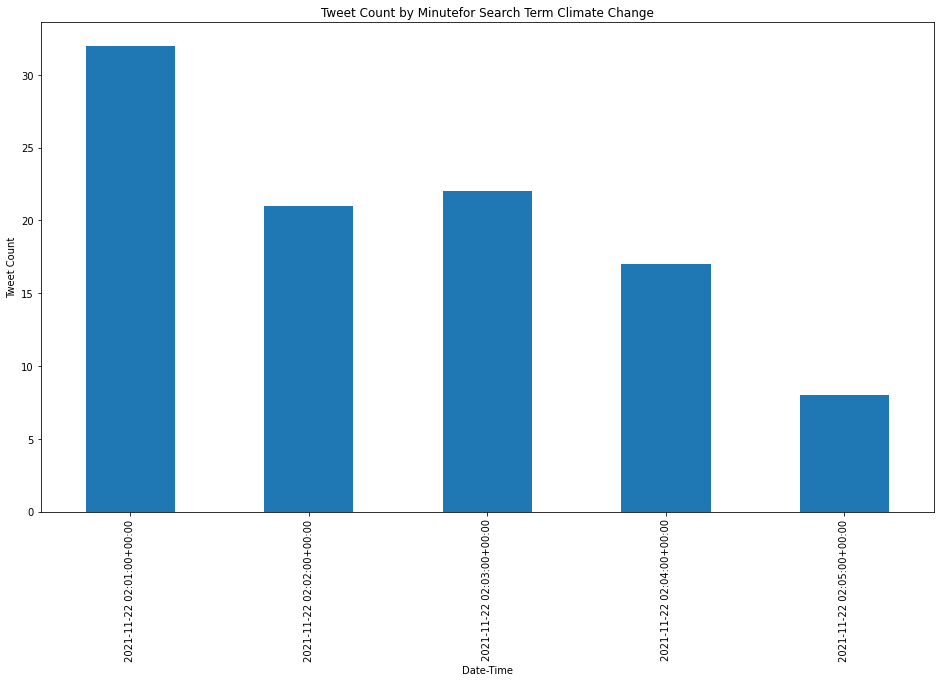

In [236]:
t = time_scale(tweets_df)
tweets_df.groupby([pd.Grouper(key = 'created_at', freq=t[0], axis = 0)]).id_str.count().plot.bar(title =('Tweet Count by ' + t[1]) + 'for Search Term ' + (search_term).title(), xlabel = 'Date-Time', ylabel = "Tweet Count")

# A, Y =  year end frequency
# M = month end frequency
# W = weekly frequency
# # D = calendar day frequency
# H = hourly frequency
# T, min = minutely frequency
# S = secondly frequency

In [238]:
emotion = nlu.load('emotion')
emo_text = emotion.predict(tweets_df.clean_tweet, output_level='document')
emo_text.head()

classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,emotion,emotion_confidence_confidence
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,fear,1.000000
1,The x Gallup Changing Childhood project tells ...,fear,1.000000
2,In the warm months animals head north to acces...,fear,0.997368
3,Bernie Sanders took more oil amp gas money tha...,surprise,0.999990
4,I believe There are only two genders All lives...,fear,1.000000


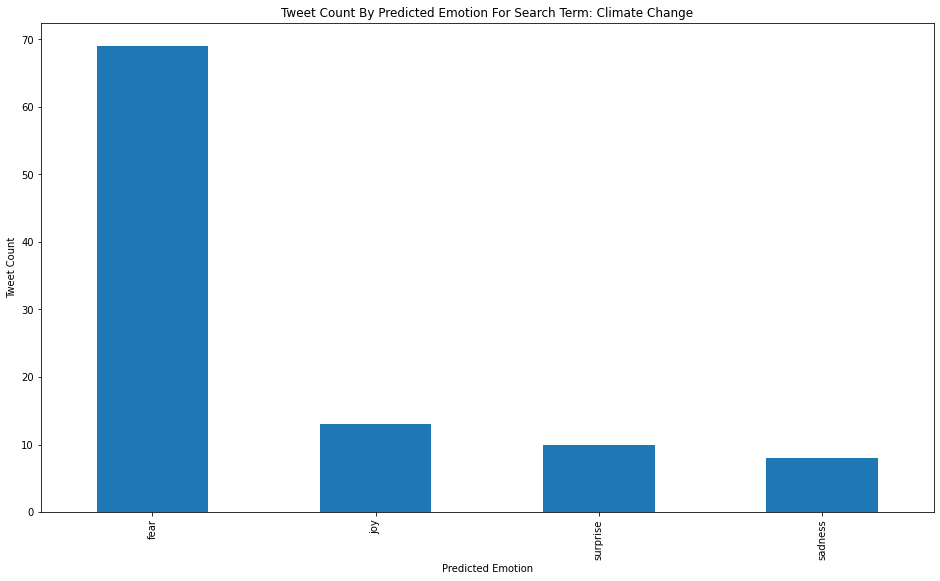

In [239]:
emo_text.emotion.value_counts().plot.bar(title =('Tweet Count by Predicted Emotion for Search Term: ' + search_term).title(), xlabel = 'Predicted Emotion', ylabel = "Tweet Count")

In [240]:
tweets_df = tweets_df.join(emo_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df

,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status,clean_tweet,emotion,emotion_confidence_confidence
0,1462603030617071617,2021-11-22 02:05:11+00:00,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,<NA>,NaN,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,fear,1.000000
1,1462603028658147330,2021-11-22 02:05:10+00:00,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,<NA>,NaN,The x Gallup Changing Childhood project tells ...,fear,1.000000
2,1462603020839972866,2021-11-22 02:05:08+00:00,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,<NA>,<NA>,NaN,In the warm months animals head north to acces...,fear,0.997368
3,1462603020743626754,2021-11-22 02:05:08+00:00,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,<NA>,<NA>,NaN,Bernie Sanders took more oil amp gas money tha...,surprise,0.999990
4,1462602994067730432,2021-11-22 02:05:02+00:00,1462602994067730432,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,<NA>,<NA>,NaN,I believe There are only two genders All lives...,fear,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,2021-11-22 02:01:07+00:00,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,<NA>,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,<NA>,<NA>,NaN,If you are going to talk about the fakeness of...,joy,0.999269
96,1462602007550873615,2021-11-22 02:01:07+00:00,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,<NA>,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 472226568, 'id_str': '472226568', 'name...",{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,False,1,False,False,<NA>,<NA>,NaN,we have always felt a deep sense of responsibi...,fear,1.000000
97,1462602005424361472,2021-11-22 02:01:06+00:00,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",<NA>,"@RantyAmyCurtis Climate change, I knew it!",False,"{'iso_language_code': 'en', 'result_type': 're...",RantyAmyCurtis,"{'id': 1461838096979443719, 'id_str': '1461838...",NaN,False,0,False,False,<NA>,<NA>,NaN,Climate change I knew it,fear,0.999924
98,1462602003041845248,2021-11-22 02:01:06+00:00,1462602003041845

In [241]:
sentiment = nlu.load('sentiment')
sentiment_text = sentiment.predict(tweets_df.clean_tweet)
sentiment_text.head()

sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentiment,sentiment_confidence
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,pos,0.707257
1,The x Gallup Changing Childhood project tells ...,pos,0.999954
2,In the warm months animals head north to acces...,neg,0.999357
3,Bernie Sanders took more oil amp gas money tha...,pos,0.986910
4,I believe There are only two genders All lives...,neg,0.846525


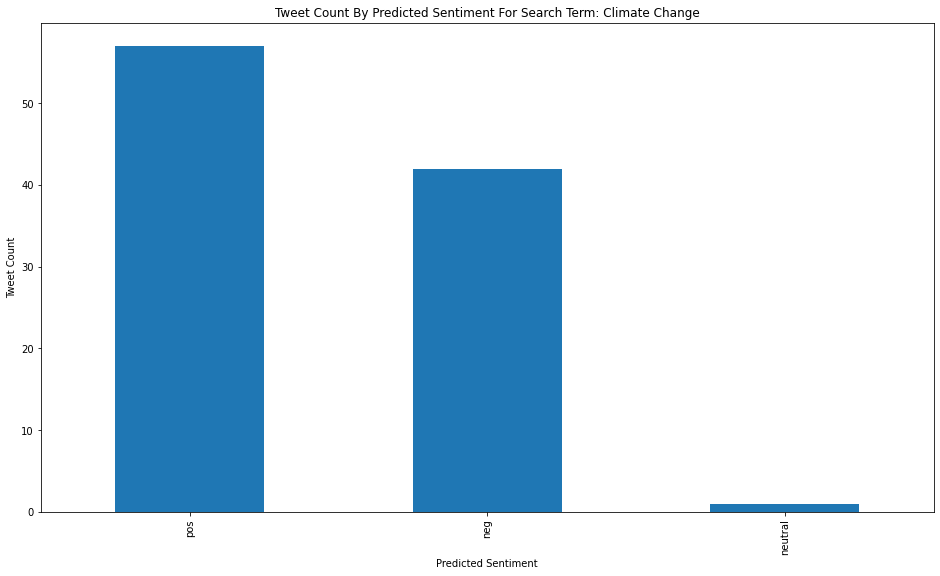

In [242]:
sentiment_text.sentiment.value_counts().plot.bar(title =('Tweet Count by Predicted Sentiment for Search Term: ' + search_term).title(), xlabel = 'Predicted Sentiment', ylabel = "Tweet Count")

In [243]:
tweets_df = tweets_df.join(sentiment_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df

,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence
0,1462603030617071617,2021-11-22 02:05:11+00:00,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,<NA>,NaN,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,fear,1.000000,pos,0.707257
1,1462603028658147330,2021-11-22 02:05:10+00:00,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,<NA>,NaN,The x Gallup Changing Childhood project tells ...,fear,1.000000,pos,0.999954
2,1462603020839972866,2021-11-22 02:05:08+00:00,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,<NA>,<NA>,NaN,In the warm months animals head north to acces...,fear,0.997368,neg,0.999357
3,1462603020743626754,2021-11-22 02:05:08+00:00,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,<NA>,<NA>,NaN,Bernie Sanders took more oil amp gas money tha...,surprise,0.999990,pos,0.986910
4,1462602994067730432,2021-11-22 02:05:02+00:00,1462602994067730432,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,<NA>,<NA>,NaN,I believe There are only two genders All lives...,fear,1.000000,neg,0.846525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,2021-11-22 02:01:07+00:00,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,<NA>,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,<NA>,<NA>,NaN,If you are going to talk about the fakeness of...,joy,0.999269,pos,0.976146
96,1462602007550873615,2021-11-22 02:01:07+00:00,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,<NA>,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 472226568, 'id_str': '472226568', 'name...",{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,False,1,False,False,<NA>,<NA>,NaN,we have always felt a deep sense of responsibi...,fear,1.000000,pos,0.999977
97,1462602005424361472,2021-11-22 02:01:06+00:00,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",<NA>,"@RantyAmyCurtis Climate change, I knew it!",False,"{'iso_language_code': 'en', 'result_type': 're...",RantyAmyCurtis,"{'id': 1461838096979443719, 'id_str': '1461838...",NaN,False,0,

In [244]:
# Sentiment Prediction Trained for Twitter
sentiment_twitter = nlu.load('en.sentiment.twitter')
sentiment_twitter_text = sentiment_twitter.predict(tweets_df.clean_tweet)
sentiment_twitter_text.head()

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentiment,sentiment_confidence
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,positive,1.000000
1,The x Gallup Changing Childhood project tells ...,positive,1.000000
2,In the warm months animals head north to acces...,negative,0.999999
3,Bernie Sanders took more oil amp gas money tha...,negative,1.000000
4,I believe There are only two genders All lives...,negative,0.620361


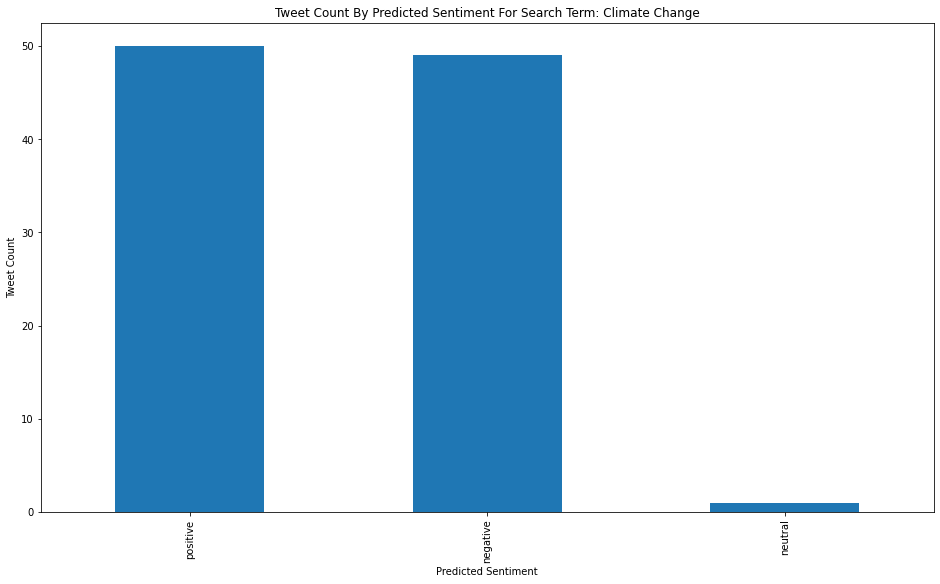

In [245]:
sentiment_twitter_text.sentiment.value_counts().plot.bar(title =('Tweet Count by Predicted Sentiment for Search Term: ' + search_term).title(), xlabel = 'Predicted Sentiment', ylabel = "Tweet Count")

In [246]:
sentiment_twitter_text = sentiment_twitter_text.rename(columns={'sentiment' : 'sentiment_twitter', 'sentiment_confidence': 'sentiment_twitter_confidence'})
tweets_df = tweets_df.join(sentiment_twitter_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df

,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence
0,1462603030617071617,2021-11-22 02:05:11+00:00,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,<NA>,NaN,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,fear,1.000000,pos,0.707257,positive,1.000000
1,1462603028658147330,2021-11-22 02:05:10+00:00,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,<NA>,NaN,The x Gallup Changing Childhood project tells ...,fear,1.000000,pos,0.999954,positive,1.000000
2,1462603020839972866,2021-11-22 02:05:08+00:00,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,<NA>,<NA>,NaN,In the warm months animals head north to acces...,fear,0.997368,neg,0.999357,negative,0.999999
3,1462603020743626754,2021-11-22 02:05:08+00:00,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,<NA>,<NA>,NaN,Bernie Sanders took more oil amp gas money tha...,surprise,0.999990,pos,0.986910,negative,1.000000
4,1462602994067730432,2021-11-22 02:05:02+00:00,1462602994067730432,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,<NA>,<NA>,NaN,I believe There are only two genders All lives...,fear,1.000000,neg,0.846525,negative,0.620361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,2021-11-22 02:01:07+00:00,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,<NA>,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,<NA>,<NA>,NaN,If you are going to talk about the fakeness of...,joy,0.999269,pos,0.976146,positive,1.000000
96,1462602007550873615,2021-11-22 02:01:07+00:00,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens...,<NA>,RT @coastfunds: “We’ve always felt a deep sens...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 472226568, 'id_str': '472226568', 'name...",{'created_at': 'Mon Nov 22 02:00:34 +0000 2021...,False,1,False,False,<NA>,<NA>,NaN,we have always felt a deep sense of responsibi...,fear,1.000000,pos,0.999977,positive,1.000000
97,1462602005424361472,2021-11-22 02:01:06+00:00,1462602005424361472,"@RantyAmyCurtis Climate change, I knew it!",<NA>,"

In [ ]:
# fakeNews = nlu.load('en.classify.fakenews')
# spam = nlu.load('en.classify.spam')
# toxic = nlu.load('en.classify.toxic')
# sarcasm = nlu.load('en.classify.sarcasm')


In [217]:
fake_news = nlu.load('en.classify.fakenews')
fake_news_text = fake_news.predict(tweets_df.clean_tweet, output_level='document')
fake_news_text

classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,fakenews,fakenews_confidence_confidence,sentence_embedding_use
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,FAKE,0.999460,"[0.0026749254, 0.06914514, -0.010042978, 0.036..."
1,The x Gallup Changing Childhood project tells ...,FAKE,0.999801,"[0.021993544, 0.010718111, 0.016943425, 0.0264..."
2,In the warm months animals head north to acces...,FAKE,1.000000,"[-0.017084384, 0.043212313, -0.016940802, 0.04..."
3,Bernie Sanders took more oil amp gas money tha...,REAL,0.990024,"[0.06058748, 0.06427892, -0.046294693, 0.04320..."
4,I believe There are only two genders All lives...,FAKE,0.619380,"[-0.051383995, -0.05805703, -0.025524732, -0.0..."
...,...,...,...,...
95,If you are going to talk about the fakeness of...,FAKE,1.000000,"[-0.0678104, -0.041009378, 0.016509341, -0.052..."
96,we have always felt a deep sense of responsibi...,FAKE,0.999995,"[0.011011127, -0.0055928105, -0.009302379, -0...."
97,Climate change I knew it,FAKE,0.999994,"[-0.048869506, 0.047704976, -0.019155974, 0.04..."
98,Apparently Greg Abbott has not done enough to ...,REAL,0.996187,"[0.024614684, 0.016333155, -0.052378826, 0.027..."


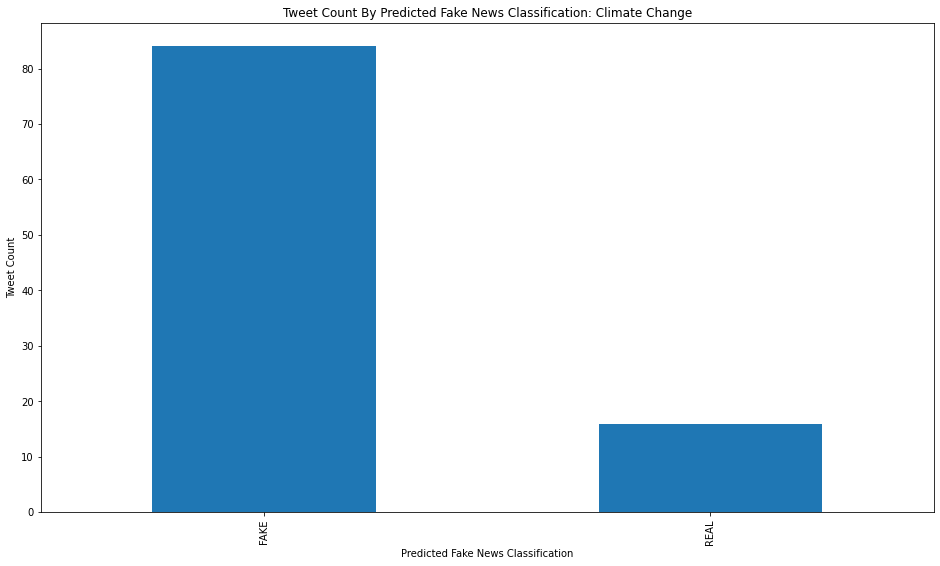

In [255]:
fake_news_text.fakenews.value_counts().plot.bar(title =('Tweet Count by Predicted Fake News Classification: ' + search_term).title(), xlabel = 'Predicted Fake News Classification', ylabel = "Tweet Count")

In [260]:
tweets_df = tweets_df.join(fake_news_text)
tweets_df.drop(['document' 'sentence_embedding_use'], inplace=True, axis =1)
tweets_df

ValueError: ignored

In [257]:
tweets_df[tweeets_df[fakenews]=='REAL']

NameError: ignored

In [251]:
tweets_df = tweets_df.join(fake_news_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df

,id,created_at,id_str,text,full_text,tweet_text,truncated,metadata,in_reply_to_screen_name,user,retweeted_status,is_quote_status,retweet_count,favorited,retweeted,possibly_sensitive,quoted_status_id_str,quoted_status,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,sentence_embedding_use
0,1462603030617071617,2021-11-22 02:05:11+00:00,1462603030617071617,"WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...","WAR IS THE SMOKING GUN OF ""CLIMATE CHANGE"" AND...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 4035053313, 'id_str': '4035053313', 'na...",NaN,False,0,False,False,False,<NA>,NaN,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,fear,1.000000,pos,0.707257,positive,1.000000,FAKE,0.999460,"[0.0026749254, 0.06914514, -0.010042978, 0.036..."
1,1462603028658147330,2021-11-22 02:05:10+00:00,1462603028658147330,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,The @UNICEF x Gallup 'Changing Childhood proje...,True,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 34159062, 'id_str': '34159062', 'name':...",NaN,False,0,False,False,False,<NA>,NaN,The x Gallup Changing Childhood project tells ...,fear,1.000000,pos,0.999954,positive,1.000000,FAKE,0.999801,"[0.021993544, 0.010718111, 0.016943425, 0.0264..."
2,1462603020839972866,2021-11-22 02:05:08+00:00,1462603020839972866,"RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...","RT @YaleE360: In the warm months, animals head...",False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 20686254, 'id_str': '20686254', 'name':...",{'created_at': 'Sun Nov 21 22:00:35 +0000 2021...,False,8,False,False,<NA>,<NA>,NaN,In the warm months animals head north to acces...,fear,0.997368,neg,0.999357,negative,0.999999,FAKE,1.000000,"[-0.017084384, 0.043212313, -0.016940802, 0.04..."
3,1462603020743626754,2021-11-22 02:05:08+00:00,1462603020743626754,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,RT @AMuchBetterFace: Bernie Sanders took more ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 461399311, 'id_str': '461399311', 'name...",{'created_at': 'Sun Nov 21 06:57:22 +0000 2021...,False,979,False,False,<NA>,<NA>,NaN,Bernie Sanders took more oil amp gas money tha...,surprise,0.999990,pos,0.986910,negative,1.000000,REAL,0.990024,"[0.06058748, 0.06427892, -0.046294693, 0.04320..."
4,1462602994067730432,2021-11-22 02:05:02+00:00,1462602994067730432,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,RT @RightWingJewess: I believe: There are only...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 779879391606087680, 'id_str': '77987939...",{'created_at': 'Sun Nov 21 14:14:17 +0000 2021...,False,73,False,False,<NA>,<NA>,NaN,I believe There are only two genders All lives...,fear,1.000000,neg,0.846525,negative,0.620361,FAKE,0.619380,"[-0.051383995, -0.05805703, -0.025524732, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1462602009995931648,2021-11-22 02:01:07+00:00,1462602009995931648,RT @Tonya_Song: If you're going to talk about ...,<NA>,RT @Tonya_Song: If you're going to talk about ...,False,"{'iso_language_code': 'en', 'result_type': 're...",<NA>,"{'id': 2920468975, 'id_str': '2920468975', 'na...",{'created_at': 'Mon Nov 22 01:03:19 +0000 2021...,False,158,False,False,<NA>,<NA>,NaN,If you are going to talk about the fakeness of...,joy,0.999269,pos,0.976146,positive,1.000000,FAKE,1.000000,"[-0.0678104, -0.041009378, 0.016509341, -0.052..."
96,1462602007550873615,2021-11-22 02:01:07+00:00,1462602007550873615,RT @coastfunds: “We’ve always felt a deep sens..

In [254]:
 spam = nlu.load('en.classify.spam')
 spam_df = spam.predict(tweets_df.clean_tweet, output_level='document')
 spam_df

classifierdl_use_spam download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,spam,spam_confidence_confidence
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,ham,1.000000
1,The x Gallup Changing Childhood project tells ...,ham,0.819342
2,In the warm months animals head north to acces...,ham,1.000000
3,Bernie Sanders took more oil amp gas money tha...,ham,1.000000
4,I believe There are only two genders All lives...,ham,1.000000
...,...,...,...
95,If you are going to talk about the fakeness of...,ham,1.000000
96,we have always felt a deep sense of responsibi...,ham,1.000000
97,Climate change I knew it,ham,1.000000
98,Apparently Greg Abbott has not done enough to ...,ham,1.000000


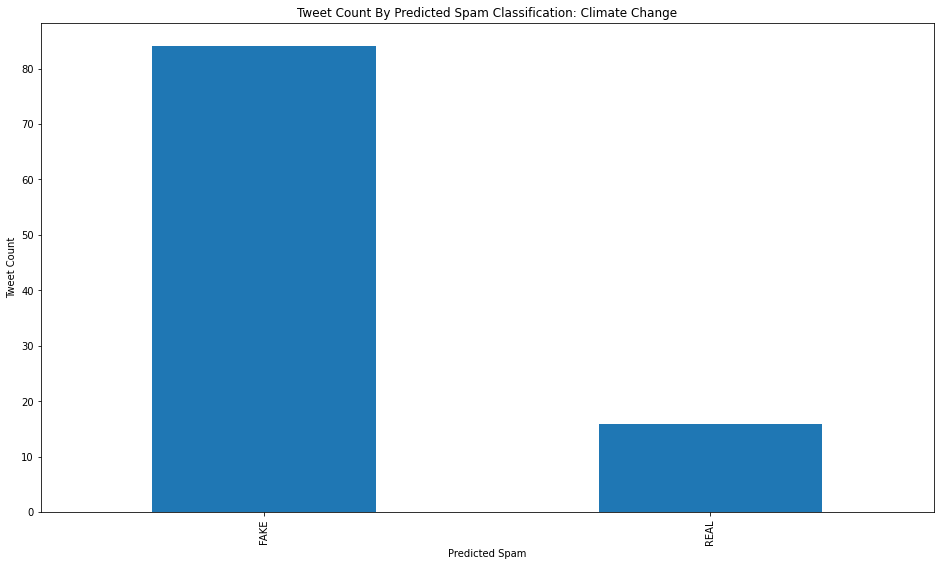

In [256]:
fake_news_text.fakenews.value_counts().plot.bar(title =('Tweet Count by Predicted Spam Classification: ' + search_term).title(), xlabel = 'Predicted Spam', ylabel = "Tweet Count")

In [214]:
yake = nlu.load('yake')
yake['yake'].setThreshold(.50)  
yake_text = yake.predict(tweets_df.clean_tweet)
yake_text

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,keywords,keywords_confidence
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,war,0.45423249266342625
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,versa,0.26804494089513314
0,WAR IS THE SMOKING GUN OF CLIMATE CHANGE AND V...,vice versa,0.1840422979793308
1,The x Gallup Changing Childhood project tells ...,gallup changing,0.2928975457250595
1,The x Gallup Changing Childhood project tells ...,changing childhood,0.2928975457250595
...,...,...,...
98,Apparently Greg Abbott has not done enough to ...,abbott,0.3534678372180142
98,Apparently Greg Abbott has not done enough to ...,abbott,0.3534678372180142
99,The other day made a great point in the debate...,versus,0.31967876007885204
99,The other day made a great point in the debate...,versus,0.31967876007885204


In [213]:
yake2 = nlu.load('yake')
yake2['deep_sentence_detector@SentenceDetectorDLModel_c83c27f46b97'].setExplodeSentences(False)
yake2['document_assembler'].setCleanupMode('inplace_full')  
yake2['yake'].setThreshold(.80)  
y2 = yake2.predict("I had thought that the yake would return a single row of keywords")

y2

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,keywords,keywords_confidence
0,I had thought that the yake would return a sin...,thought,0.749415309854081
0,I had thought that the yake would return a sin...,return,0.749415309854081
0,I had thought that the yake would return a sin...,keywords,0.35454977464777665


In [190]:
dy2.set_index('keywords', inplace = True)
y2

,document,keywords_confidence
keywords,,
thought,I had thought that the yake would return a sin...,0.749415309854081
return,I had thought that the yake would return a sin...,0.749415309854081
keywords,I had thought that the yake would return a sin...,0.35454977464777665


In [197]:
y3 =  yake_text.groupby('document')['keywords'].apply(list)
y3

document
50 50 climate change will be the blame.                                                                                                                                                                                                                                                                   [climate, change, blame]
A society of 50 000 physicists Multiple lines of evidence strongly support the finding that anthropogenic greenhouse ga                                                                                                                                                           [ga, greenhouse ga, anthropogenic greenhouse ga]
Anyone who watches imaceleb and enjoys seeing animals getting eaten alive crushed and used for entertainment then says they care about climate change the environment and protecting species is an absolute hypocrite. You cannot do both and hold your head up high. cruelty                           [anyone, watches, cruelty]
Apparently Greg Abbott

In [ ]:
# yake.print_info()
# yake['yake'].setMinNGrams(1)
# yake['yake'].setMaxNGrams(3)
# yake_text = yake.predict(text.cleanText)
# yake_text

The following parameters are configurable for this NLU pipeline (You can copy paste the examples) :
>>> pipe['yake'] has settable params:
pipe['yake'].setMinNGrams(1)                                                                                 | Info: Minimum N-grams a keyword should have | Currently set to : 1
pipe['yake'].setMaxNGrams(3)                                                                                 | Info: Maximum N-grams a keyword should have | Currently set to : 3
pipe['yake'].setNKeywords(3)                                                                                 | Info: Number of Keywords to extract | Currently set to : 3
pipe['yake'].setWindowSize(3)                                                                                | Info: Window size for Co-Occurrence | Currently set to : 3
pipe['yake'].setThreshold(-1.0)                                                                              | Info: Keyword Score threshold | Currently set to : -1.0

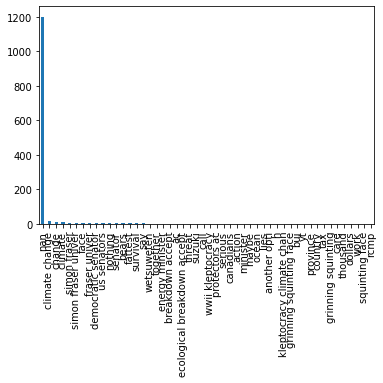

In [ ]:
yake_text.keywords.value_counts()[:50].plot.bar()

#If df had a column with multiple keywords use:
# yake_text.explode('keywords).keywords.value_counts()[0:100].plot.bar()

In [ ]:
# yake.print_info()
# yake['yake'].setMinNGrams(3)
# yake['yake'].setMaxNGrams(3)
# yake_text = yake.predict(text.text)
# yake_text

,document,keywords,keywords_confidence
0,It being hot as fuck thanksgivings week in LA ...,la,0.5798862558280943
0,It being hot as fuck thanksgivings week in LA ...,change,0.35454977464777665
0,It being hot as fuck thanksgivings week in LA ...,climate change,0.361850536639813
1,RT @AMuchBetterFace: Bernie Sanders took more ...,bernie sanders,0.29364120139579386
1,RT @AMuchBetterFace: Bernie Sanders took more ...,us senators,0.29364120139579386
...,...,...,...
498,RT @harrisonjaime: Stop it! Can y’all at least...,stop,0.5013694563024311
498,RT @harrisonjaime: Stop it! Can y’all at least...,sunday,0.5592365643538999
499,RT @tan123: Reuters now informs us that “Month...,rt,0.42438555357534796
499,RT @tan123: Reuters now informs us that “Month...,reuters,0.6519458916275727


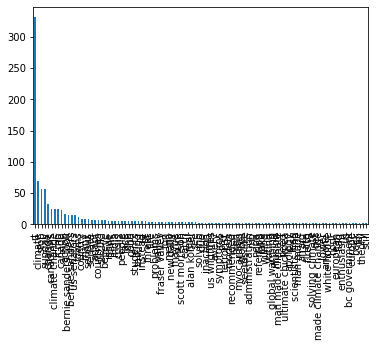

In [ ]:
yake_text.keywords.value_counts()[0:100].plot.bar()

In [ ]:
pos = nlu.load('pos')

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [ ]:
pos.predict('Part of speech assigns each token in a sentence a gramatical label')

#Simple Examples -> PO section

,pos,token
0,NN,Part
0,IN,of
0,NN,speech
0,NNS,assigns
0,DT,each
0,NN,token
0,IN,in
0,DT,a
0,NN,sentence
0,DT,a


In [ ]:
ner = nlu.load('ner')
ner.predict("Angela Merkel from Germany and the American Donald Trump don't share many opinions")

onto_recognize_entities_sm download started this may take some time.
Approx size to download 160.1 MB
[OK!]


,document,entities,entities_class,entities_confidence
0,Angela Merkel from Germany and the American Do...,Angela Merkel,PERSON,0.99355
0,Angela Merkel from Germany and the American Do...,Germany,GPE,0.9998
0,Angela Merkel from Germany and the American Do...,American,NORP,0.984
0,Angela Merkel from Germany and the American Do...,Donald Trump,PERSON,0.97805


In [ ]:
# output_level
# document
# Sentence
# ner.predict(['Angela Merkel from Germany and the American Donald Trump dont share many opinions. Jimmy likes candy'], output_level = 'document')
# ner.predict(['Angela Merkel from Germany and the American Donald Trump dont share many opinions. Jimmy likes candy'], output_level = 'sentence')
# ner.predict(['Angela Merkel from Germany and the American Donald Trump dont share many opinions. Jimmy likes candy'], output_level = 'chunk')
ner.predict(['Angela Merkel from Germany and the American Donald Trump dont share many opinions. Jimmy likes candy'], output_level = 'token')

,entities,entities_class,entities_confidence,token
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",Angela
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",Merkel
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",from
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",Germany
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",and
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",the
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",American
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",Donald
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",Trump
0,"[Angela Merkel, Germany, American, Donald Trum...","[PERSON, GPE, NORP, PERSON, PERSON]","[0.99395, 0.9998, 0.9904, 0.9783, 0.9831]",dont


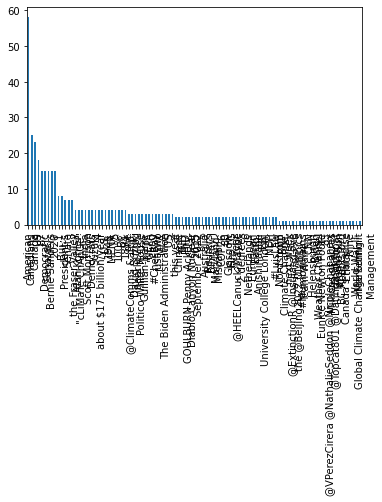

In [ ]:
ner.predict(text.text, output_level='chunk').entities.value_counts()[:100].plot.bar()


In [ ]:
ner_text = ner.predict(text.text, output_level='document')
ner_text.head()

,document,entities,entities_class,entities_confidence
0,It being hot as fuck thanksgivings week in LA ...,[LA],[GPE],[0.9131]
1,RT @AMuchBetterFace: Bernie Sanders took more ...,"[Bernie Sanders, 87, US, 2020, Democratic, Sen...","[PERSON, CARDINAL, GPE, DATE, NORP, PERSON]","[0.91065, 0.7374, 0.9882, 0.7458, 0.8453, 0.19]"
2,From November 29 the flagship event by Sustain...,"[November 29, Sustainable Finance Geneva, Buil...","[DATE, ORG]","[0.93275, 0.42036]"
3,RT @brandybruja: Some people should get a real...,NaN,NaN,NaN
4,"@VicIndyMovement Oh FFS, quit with your woke-G...",NaN,NaN,NaN


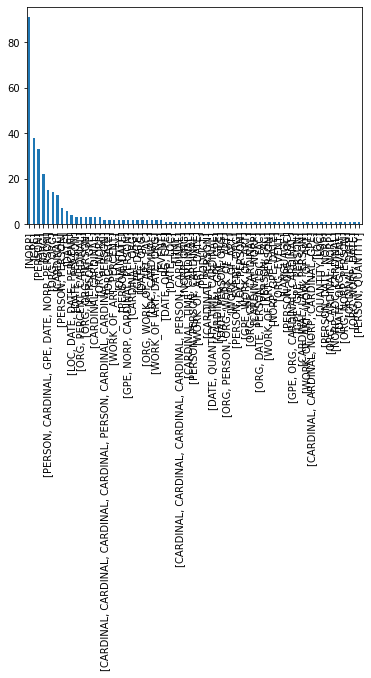

In [ ]:
ner_text.entities_class.value_counts()[:100].plot.bar()

In [ ]:
# sentence similarity - compares one string to another, embedding turn words and sentences to vectors, use cos angle to compare if 0 very similare, 90 not similar

bert = nlu.load('embed_sentence.bert')

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [ ]:
bert_text =bert.predict(text.text, output_level='document')
bert_text

,document
0,It being hot as fuck thanksgivings week in LA ...
1,RT @AMuchBetterFace: Bernie Sanders took more ...
2,From November 29 the flagship event by Sustain...
3,RT @brandybruja: Some people should get a real...
4,"@VicIndyMovement Oh FFS, quit with your woke-G..."
...,...
495,RT @pogoboii31: So the media is seriously push...
496,@BernieB15757341 @Staroxvia i was being faceti...
497,#climate #change The 11TH HOUR FOR THE EARTH #...
498,RT @harrisonjaime: Stop it! Can y’all at least...


In [ ]:
text.head()

,created_at,id,text
0,Sun Nov 21 20:52:14 +0000 2021,1462524274908950534,It being hot as fuck thanksgivings week in LA ...
1,Sun Nov 21 20:52:10 +0000 2021,1462524260010844162,RT @AMuchBetterFace: Bernie Sanders took more ...
2,Sun Nov 21 20:52:09 +0000 2021,1462524255065755669,From November 29 the flagship event by Sustain...
3,Sun Nov 21 20:52:07 +0000 2021,1462524248447193093,RT @brandybruja: Some people should get a real...
4,Sun Nov 21 20:52:05 +0000 2021,1462524236858212352,"@VicIndyMovement Oh FFS, quit with your woke-G..."


In [ ]:
nlu.load('bert').predict('NLU offers the latest embeddings in one line', get_embeddings = True)

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,token,word_embedding_bert
0,NLU,"[-2.394416, 0.0010310598, 0.4201642, -0.817292..."
0,offers,"[-1.1124685, -0.4454758, 0.031745672, -1.19997..."
0,the,"[-1.0090525, 0.8201566, -0.13695294, -1.137018..."
0,latest,"[-0.48124883, -0.08496487, 0.3776035, -0.91002..."
0,embeddings,"[-1.1933347, 0.20178503, -0.015017837, 0.00247..."
0,in,"[-0.45985144, 0.09733085, -0.38610506, -2.5335..."
0,one,"[0.28250837, -0.36252847, -0.39459234, -0.1664..."
0,line,"[0.20004824, 0.6721987, -0.9191772, -1.3326215..."


In [ ]:

'https://api.twitter.com/2/tweets?ids=1212092628029698048&tweet.fields=attachments,author_id,context_annotations,created_at,entities,geo,id,in_reply_to_user_id,lang,possibly_sensitive,public_metrics,referenced_tweets,source,text,withheld&expansions=referenced_tweets.id' --header 'Authorization: Bearer $BEARER_TOKEN'